In [1]:
# Compare two matchms tables

In [2]:
from pipeline_utils import get_galaxy_filename
import numpy as np
import pandas as pd
from matplotlib_venn import venn2 as venn2_
import matplotlib.pyplot as plt


def venn2(*args,):
    v = venn2_(*args, set_labels = ('Predicted', 'Ground'))
    v.get_patch_by_id('100').set_color('red')
    v.get_patch_by_id('010').set_color('orange')
    v.get_patch_by_id('110').set_color('green')

/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [4]:
fres1 = get_galaxy_filename('3_matchms output formatter _get-thresholded-data_ on data 129', '../data', None)
fres2 = get_galaxy_filename('4_matchms output formatter _get-thresholded-data_ on data 148', '../data', None)

fref = "tmp/6_KC_Confirmed_seminalplasma.csv.csv"



# reference_lib = "../data/1_rcx_gc-orbitrap_metabolites_20210817.msp.msp"
# concs = ["all"]
# # if the predictions were generated in this galaxy session set to True
# is_fresh = False
# suffix = "" if is_fresh else ".txt"


%load_ext autoreload
%autoreload 2

FileNotFoundError: [Errno 2] No such file or directory: '../data'

In [5]:
fres1

'../data/3_matchms output formatter _get-thresholded-data_ on data 129 and data 128.tsv'

In [6]:
ref = pd.read_csv(fref)
res1 = pd.read_csv(fres1, sep="\t", index_col=0)
res2 = pd.read_csv(fres2, sep="\t", index_col=0)

In [119]:
len(res1.groupby("query").mean())

41

In [120]:
len(res1), len(res2)

(143, 147)

In [121]:
ground = set(ref["Metabolite name"])
# orig = set(res1.reference) 
# new = set(res2.reference) 

In [166]:
th_m = 1
th_s = 0.4
top_considered = 1

In [173]:
# only set 
orig = res1[((res1.matches > th_m) & (res1.score > th_s))].reference


# the top compound according to prespecified "best" criterion

# add helper collumn - the best criterion in the score as in rcx galaxy formatter
res1["total"] = res1["score"]
res2["total"] = res2["score"]#

x  = res1[((res1.matches > th_m) & (res1.score > th_s))]
x = x.reset_index()

x = x.loc[x.groupby('query')['total'].idxmax(), ['query', 'reference', 'total']]
orig = x.reference





# different perspective - how much of recovered spectra were sucesfully matched?
# i sucessful mathcing is if the correct compound is matched in top 3(5) compounds sorted by score now
# the linking of detected spectra to annotations is via RT




,query,reference,total
0,C02,Lysine_4TMS,0.922810
2,C06,Fructose_5TMS isomer 2,0.876681
5,C08,Citric acid_4TMS,0.874922
7,C10,Myo-inositol_6TMS,0.915567
8,C16,Uridine_4TMS isomer 1,0.602506
9,C17,Serine_3TMS,0.825573
10,C19,Aspartic acid_3TMS isomer,0.909835
14,C26,Threonine_3TMS spectra 1,0.796540
16,C30,Asparagine_3TMS,0.420921
17,C39,Histidine_3TMS,0.839636


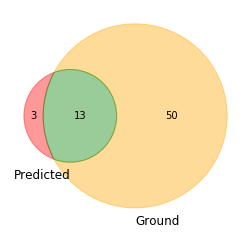

In [184]:
orig = res1[((res1.matches > th_m) & (res1.score > th_s))].reference
# venn2((set(orig), ground))
# orig
#res1[((res1.matches > th_m) & (res1.score > th_s))].groupby(["query", "reference"])["total"].max()


x  = res1[((res1.matches > th_m) & (res1.score > th_s))]
x = x.reset_index()

x = x.loc[x.groupby('query')['total'].idxmax(), ['query', 'reference', 'total']]
orig = x.reference


venn2((set(orig), ground))
orig
x


In [175]:
set(orig).intersection(ground)

{'Acetylgalactosamine_5TMS isomer 1',
 'Asparagine_3TMS',
 'Aspartic acid_3TMS isomer',
 'Citric acid_4TMS',
 'Fructose_5TMS isomer 2',
 'Histidine_3TMS',
 'Lysine_4TMS',
 'Myo-inositol_6TMS',
 'Palmitic acid_1TMS',
 'Phenylalanine_2TMS',
 'Serine_3TMS',
 'Stearic acid_1TMS',
 'Threonine_3TMS spectra 1'}

,query,reference,total
0,C01,Lysine_4TMS,0.922073
2,C03,Fructose_5TMS isomer 2,0.876672
5,C07,Citric acid_4TMS,0.874352
7,C11,Myo-inositol_6TMS,0.915567
9,C17,Glutamic acid_3TMS spectra 2,0.931333
10,C19,Aspartic acid_3TMS isomer,0.909993
14,C21,Uridine_4TMS isomer 1,0.602503
15,C23,Serine_3TMS,0.825573
16,C25,Palmitic acid_1TMS,0.513152
18,C26,Acetylgalactosamine_5TMS isomer 1,0.452095


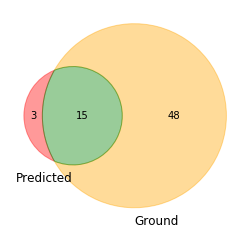

In [176]:
new = res2[((res2.matches > th_m) & (res2.score > th_s))].reference
x  = res2[((res2.matches > th_m) & (res2.score > th_s))]
x = x.reset_index()

x = x.loc[x.groupby('query')['total'].idxmax(), ['query', 'reference', 'total']]
new = x.reference


venn2((set(new), ground))
x

In [177]:
set(new).difference(orig).intersection(ground)

{'Glutamic acid_3TMS spectra 2', 'Leucine_2TMS'}

In [178]:
set(new).intersection(ground)

{'Acetylgalactosamine_5TMS isomer 1',
 'Asparagine_3TMS',
 'Aspartic acid_3TMS isomer',
 'Citric acid_4TMS',
 'Fructose_5TMS isomer 2',
 'Glutamic acid_3TMS spectra 2',
 'Histidine_3TMS',
 'Leucine_2TMS',
 'Lysine_4TMS',
 'Myo-inositol_6TMS',
 'Palmitic acid_1TMS',
 'Phenylalanine_2TMS',
 'Serine_3TMS',
 'Stearic acid_1TMS',
 'Threonine_3TMS spectra 1'}

In [179]:
orig = np.zeros(shape=(20, 20))
new = orig.copy()

stat_orig = np.ones(63) * (100)
stat_new = stat_orig.copy()
for i, n_m in enumerate(range(1,21)):
    for j, n_s in enumerate(np.arange(0,1,0.05)):
        for res, grid, stat in zip([res1, res2], [orig, new], [stat_orig, stat_new]):
            p = set(res[((res.matches > n_m) & (res.score > n_s))].reference)
            
            x  = res[((res.matches > n_m) & (res.score > n_s))]
            x = x.reset_index()

            x = x.loc[x.groupby('query')['total'].idxmax(), ['query', 'reference', 'total']]
            p = set(x.reference)
            
            TP = len(p.intersection(ground))
            FP = len(p.difference(ground))
            FN = len(ground.difference(p))
            stat[TP] = min(FP, stat[TP])
            grid[i,j] = TP/(TP + 0.5*(FN+FP)) if (TP + 0.5*(FN+FP)) != 0 else 0
stat_orig[stat_orig == 100] = np.nan
stat_new[stat_new == 100] = np.nan

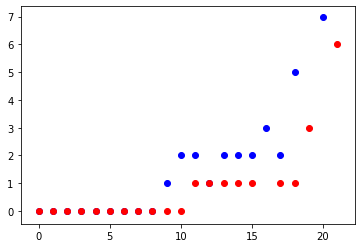

In [180]:
plt.scatter(x=np.arange(63), y=stat_orig, color="blue")
plt.scatter(x=np.arange(63), y=stat_new, color = "red")

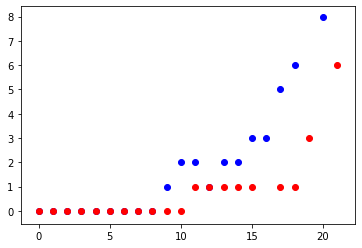

In [149]:
plt.scatter(x=np.arange(63), y=stat_orig, color="blue")
plt.scatter(x=np.arange(63), y=stat_new, color = "red")

In [43]:
stat_orig - stat_new

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,  0.,
        1.,  1.,  1., nan,  1.,  4., nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

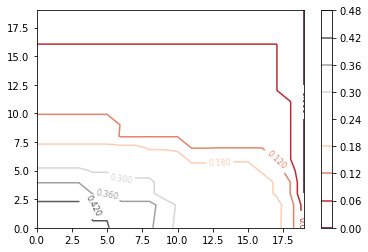

In [44]:
c = plt.contour(new, cmap='RdGy')
plt.clabel(c, inline=True, fontsize=8)

plt.colorbar()

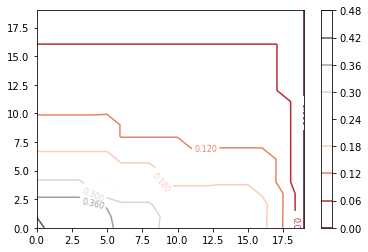

In [45]:
c = plt.contour(orig, cmap='RdGy')
plt.clabel(c, inline=True, fontsize=8)

plt.colorbar()


In [46]:
new.sum()

56.818564573400565

In [47]:
orig.sum()

50.58450836858507

In [48]:
th_m, th_s = 5, 0.4
orig = res1[((res1.matches > th_m) & (res1.score > th_s))].reference
new = res2[((res2.matches > th_m) & (res2.score > th_s))].reference


In [49]:
set(orig) -set(new)

set()

In [50]:
set(new) -set(orig)

{'Acetylgalactosamine_4TMS',
 'Acetylgalactosamine_5TMS isomer 1',
 'Aspartic acid_3TMS isomer',
 'Glutamic acid_3TMS spectra 1',
 'Glutamic acid_3TMS spectra 2',
 'Palmitic acid_1TMS'}

In [51]:
set(new) - ground

{'Gluconic acid-1,4-lactone',
 'Glucuro-3,6-lactone_3TMS isomer 1',
 'Glutamic acid_3TMS spectra 1',
 'Isocitric acid_4TMS',
 'Uridine_4TMS isomer 1'}

In [52]:
set(orig) - ground

{'Gluconic acid-1,4-lactone',
 'Glucuro-3,6-lactone_3TMS isomer 1',
 'Isocitric acid_4TMS',
 'Uridine_4TMS isomer 1'}

In [188]:
!pwd

/mnt/volume/shared/ces-nya/nfs4/home/umsa/job_working_directory_object/034/34762/working/jupyter/raims
